In [1]:
import pandas as pd 
import torch 
from matplotlib import pyplot as plt 
import seaborn as sbn 
import numpy as np 

In [2]:
preds = pd.read_csv('/home/teddy/local/workflow_outputs/tkgdti/TargetomeKG_02/complex2/aggregated_predictions.csv')
data = torch.load('/home/teddy/local/workflow_outputs/tkgdti/TargetomeKG_02/Data.pt')
targetome = pd.read_csv('~/local/data/targetome_extended-01-23-25.csv')

/tmp/ipykernel_787/150045787.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('/home/teddy/local/workflow_outputs/tkgdti/TargetomeKG_02/Data.pt')
/home/

In [3]:
inchi2idx = {k:i for i,k in enumerate(data.node_name_dict['drug'])}
gene2idx = {k:i for i,k in enumerate(data.node_name_dict['gene'])}
uni2gene = preds[['uniprot_id', 'gene_symbol']].set_index('uniprot_id').to_dict()['gene_symbol']

targetome = targetome[['inchi_key','uniprot_id', 'assay_type', 'assay_relation', 'assay_value']].drop_duplicates() 
targetome = targetome[lambda x: x.assay_relation == '=']
targetome = targetome.groupby(['inchi_key', 'uniprot_id']).agg({'assay_value': 'median'}).reset_index()
targetome = targetome.assign(gene_symbol = targetome.uniprot_id.map(uni2gene))
targetome = targetome.assign(drug = targetome.inchi_key.map(inchi2idx))
targetome = targetome.assign(protein = targetome.gene_symbol.map(gene2idx))
targetome = targetome[lambda x: x.drug.notna() & x.protein.notna() & x.assay_value.notna()]
targetome.head() 

,inchi_key,uniprot_id,assay_value,gene_symbol,drug,protein
58,AAAQFGUYHFJNHI-SFHVURJKSA-N,O60885,100.0000,BRD4,0.0,1385.0
59,AAAQFGUYHFJNHI-SFHVURJKSA-N,P25440,101.6000,BRD2,0.0,1383.0
61,AAAQFGUYHFJNHI-SFHVURJKSA-N,Q15059,50.7000,BRD3,0.0,1384.0
62,AAAQFGUYHFJNHI-SFHVURJKSA-N,Q58F21,86.0000,BRDT,0.0,1389.0
218,AADCDMQTJNYOSS-LBPRGKRZSA-N,P14416,0.1085,DRD2,2.0,3540.0


In [4]:
preds = preds.merge(targetome, left_on=['inchikey', 'uniprot_id'], right_on=['inchi_key', 'uniprot_id'], how='left')
preds.head() 

,drug_x,protein_x,score,fnr_est,fpr_est,tnr_est,tpr_est,fnr_est_mean,fpr_est_mean,tnr_est_mean,...,in_n_folds,inchikey,gene_symbol_x,inhibitor,uniprot_id,inchi_key,assay_value,gene_symbol_y,drug_y,protein_y
0,1221,1504,"[-9.826996, -9.836588, -9.080676, -9.509457, -...","[0.928452905973923, 0.9041466702906138, 0.9962...","[1.7675160936421071e-06, 9.914980373821179e-07...","[0.9999982324839063, 0.9999990085019627, 0.999...","[0.07154709402607691, 0.09585332970938616, 0.0...",0.952664,7.043093e-07,0.999999,...,9,NDDAHWYSQHTHNT-UHFFFAOYSA-N,CA2,Indapamide,P00918,NDDAHWYSQHTHNT-UHFFFAOYSA-N,283.4425,CA2,1221.0,1504.0
1,2119,3542,"[-9.415058, -9.796532, -9.234072, -9.285328, -...","[0.985755241700484, 0.9100676394911715, 0.9909...","[1.1763479205695727e-07, 8.073147968496051e-07...","[0.9999998823652079, 0.9999991926852032, 0.999...","[0.014244758299516009, 0.08993236050882847, 0....",0.948085,1.026899e-06,0.999999,...,10,WSPOMRSOLSGNFJ-AUWJEWJLSA-N,DRD4,Chlorprothixene,P21917,NaN,NaN,NaN,NaN,NaN
2,512,7523,"[-9.687541, -9.4396715, -9.669943, -9.548048, ...","[0.9597587998925831, 0.979459349631078, 0.9352...","[7.598994776679323e-07, 9.850631469196595e-09,...","[0.9999992401005223, 0.9999999901493685, 0.999...","[0.040241200107417024, 0.020540650368922005, 0...",0.931118,1.130676e-06,0.999999,...,8,GFUITADOEPNRML-SJORKVTESA-N,MMP2,Cipemastat,P08253,GFUITADOEPNRML-SJORKVTESA-N,154.0000,MMP2,512.0,7523.0
3,1733,1510,"[-9.196262, -9.780499, -9.243512, -9.388377, -...","[0.994908116071998, 0.912971954501018, 0.99081...","[1.0056529641846188e-08, 7.430884841796973e-07...","[0.9999999899434704, 0.9999992569115158, 0.999...","[0.005091883928001904, 0.08702804549898198, 0....",0.924957,2.153621e-06,0.999998,...,10,SETFNECMODOHTO-UHFFFAOYSA-N,CA7,Indisulam,P43166,SETFNECMODOHTO-UHFFFAOYSA-N,122.0000,CA7,1733.0,1510.0
4,1034,9568,"[-9.753704, -9.538239, -9.546149, -9.661387, -...","[0.9427571623100217, 0.9678208619150077, 0.954...","[1.2379528867439832e-06, 9.914759372299242e-08...","[0.9999987620471132, 0.9999999008524062, 0.999...","[0.05724283768997831, 0.03217913808499234, 0.0...",0.917060,1.578284e-06,0.999998,...,9,LMJFJIDLEAWOQJ-CQSZACIVSA-N,PIK3CG,Azd-8186,P48736,LMJFJIDLEAWOQJ-CQSZACIVSA-N,3337.5000,PIK3CG,1034.0,9568.0


In [5]:
preds.sort_values(by='fnr_est_mean', ascending=False).head(15)[['inhibitor', 'gene_symbol_x', 'score_mean', 'assay_value']].style.hide()

inhibitor,gene_symbol_x,score_mean,assay_value
Indapamide,CA2,-9.486427,283.442500
Chlorprothixene,DRD4,-9.522669,nan
Cipemastat,MMP2,-9.700436,154.000000
Indisulam,CA7,-9.655952,122.000000
Azd-8186,PIK3CG,-9.762557,3337.500000
Sabcomeline,CHRM5,-9.771252,123.000000
Methylbenactyzium,CHRM5,-9.771980,nan
Tramadol,OPRM1,-9.723275,1800.000000
Pracinostat,HDAC7,-9.782588,107.000000
Alpelisib,PIK3CB,-9.791683,1620.000000


In [ ]:
# proportion of predictions that have targetome annotation (greater than 100nM)
(~preds.assay_value.isna()).mean()

np.float64(0.38626408010012514)

In [7]:
preds.shape[0]

6392

In [8]:
preds = preds.assign(pKd = -(np.log10(preds.assay_value)))

In [9]:
preds.head() 

,drug_x,protein_x,score,fnr_est,fpr_est,tnr_est,tpr_est,fnr_est_mean,fpr_est_mean,tnr_est_mean,...,inchikey,gene_symbol_x,inhibitor,uniprot_id,inchi_key,assay_value,gene_symbol_y,drug_y,protein_y,pKd
0,1221,1504,"[-9.826996, -9.836588, -9.080676, -9.509457, -...","[0.928452905973923, 0.9041466702906138, 0.9962...","[1.7675160936421071e-06, 9.914980373821179e-07...","[0.9999982324839063, 0.9999990085019627, 0.999...","[0.07154709402607691, 0.09585332970938616, 0.0...",0.952664,7.043093e-07,0.999999,...,NDDAHWYSQHTHNT-UHFFFAOYSA-N,CA2,Indapamide,P00918,NDDAHWYSQHTHNT-UHFFFAOYSA-N,283.4425,CA2,1221.0,1504.0,-2.452465
1,2119,3542,"[-9.415058, -9.796532, -9.234072, -9.285328, -...","[0.985755241700484, 0.9100676394911715, 0.9909...","[1.1763479205695727e-07, 8.073147968496051e-07...","[0.9999998823652079, 0.9999991926852032, 0.999...","[0.014244758299516009, 0.08993236050882847, 0....",0.948085,1.026899e-06,0.999999,...,WSPOMRSOLSGNFJ-AUWJEWJLSA-N,DRD4,Chlorprothixene,P21917,NaN,NaN,NaN,NaN,NaN,NaN
2,512,7523,"[-9.687541, -9.4396715, -9.669943, -9.548048, ...","[0.9597587998925831, 0.979459349631078, 0.9352...","[7.598994776679323e-07, 9.850631469196595e-09,...","[0.9999992401005223, 0.9999999901493685, 0.999...","[0.040241200107417024, 0.020540650368922005, 0...",0.931118,1.130676e-06,0.999999,...,GFUITADOEPNRML-SJORKVTESA-N,MMP2,Cipemastat,P08253,GFUITADOEPNRML-SJORKVTESA-N,154.0000,MMP2,512.0,7523.0,-2.187521
3,1733,1510,"[-9.196262, -9.780499, -9.243512, -9.388377, -...","[0.994908116071998, 0.912971954501018, 0.99081...","[1.0056529641846188e-08, 7.430884841796973e-07...","[0.9999999899434704, 0.9999992569115158, 0.999...","[0.005091883928001904, 0.08702804549898198, 0....",0.924957,2.153621e-06,0.999998,...,SETFNECMODOHTO-UHFFFAOYSA-N,CA7,Indisulam,P43166,SETFNECMODOHTO-UHFFFAOYSA-N,122.0000,CA7,1733.0,1510.0,-2.086360
4,1034,9568,"[-9.753704, -9.538239, -9.546149, -9.661387, -...","[0.9427571623100217, 0.9678208619150077, 0.954...","[1.2379528867439832e-06, 9.914759372299242e-08...","[0.9999987620471132, 0.9999999008524062, 0.999...","[0.05724283768997831, 0.03217913808499234, 0.0...",0.917060,1.578284e-06,0.999998,...,LMJFJIDLEAWOQJ-CQSZACIVSA-N,PIK3CG,Azd-8186,P48736,LMJFJIDLEAWOQJ-CQSZACIVSA-N,3337.5000,PIK3CG,1034.0,9568.0,-3.523421


In [10]:
preds[['score_mean', 'pKd']].corr(method='spearman')

,score_mean,pKd
score_mean,1.000000,0.124602
pKd,0.124602,1.000000


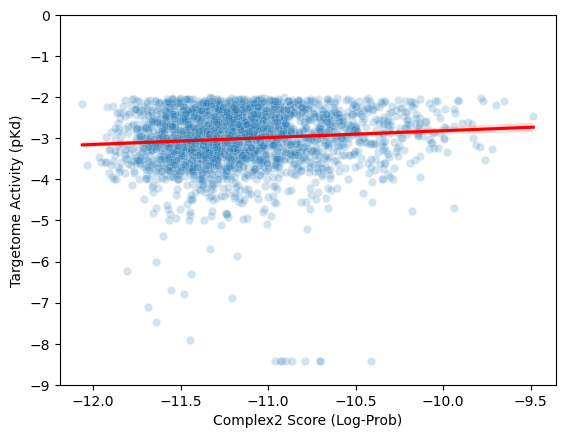

In [15]:
plt.figure() 
sbn.scatterplot(x='score_mean', y='pKd', data=preds, alpha=0.2) 
sbn.regplot(x='score_mean', y='pKd', data=preds, scatter=False, line_kws={'color': 'red'}) 
plt.xlabel('Complex2 Score (Log-Prob)')
plt.ylabel('Targetome Activity (pKd)')
plt.ylim(-9,0)
plt.show()

In [12]:
_bins = np.logspace(np.log10(targetome.assay_value.min()), np.log10(targetome.assay_value.max()), 25)

plt.figure()
plt.hist(targetome.assay_value, bins=_bins, density=True, color='blue', alpha=0.5, label='Targetome all')
plt.hist(preds.assay_value, bins=_bins, density=True, color='red', alpha=0.5, label='Predictions')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel('Targetome Assay Value (Log nM)')
plt.show()


/tmp/ipykernel_787/1063483169.py:1: RuntimeWarning: divide by zero encountered in log10
  _bins = np.logspace(np.log10(targetome.assay_value.min()), np.log10(targetome.assay_value.max()), 25)
/home/teddy/miniconda3/envs/tkgdti/lib/python3.12/site-packages/numpy/_core/function_base.py:162: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/teddy/miniconda3/envs/tkgdti/lib/python3.12/site-packages/numpy/_core/function_base.py:172: RuntimeWarning: invalid value encountered in add
  y += start


ValueError: Data has no positive values, and therefore cannot be log-scaled.

<Figure size 640x480 with 1 Axes>

In [ ]:
preds[lambda x: x.assay_value.isna()].sort_values(by='fnr_est_mean', ascending=False).head(10)[['inhibitor', 'gene_symbol_x', 'uniprot_id']].style.hide()

inhibitor,gene_symbol_x,uniprot_id
Chlorprothixene,DRD4,P21917
Methylbenactyzium,CHRM5,P08912
Rgb-286638,CCNA2,P20248
Darigabat,GABRA2,P47869
Sertindole,HTR2B,P41595
Alprazolam,GABRB3,P28472
Atracurium,CHRNB2,P17787
Tofimilast,PDE4C,Q08493
Cyclamic Acid,CA2,P00918
Lysergide,HTR1B,P28222


In [17]:
preds[lambda x: x.assay_value.isna()].shape[0]

3923

In [18]:
preds.shape[0]

6392